In [1]:
from pathlib import Path
import sys
pwd = str(Path("..").absolute())
sys.path.insert(0, pwd)

from Pyrser import pyrser
from Node import Node, FileNode, FncNode
from Utils.PyrserHelpers import xfs, dfs_generator
import graphviz; from graphviz import Digraph

In [2]:
file = "/home/kemri/Projects/pyrser/Utils/PyrserHelpers.py"
output = pyrser(file)

In [3]:
output

FileNode(name='PyrserHelpers.py', scope=[1, 149], location=/home/kemri/Projects/pyrser/Utils/PyrserHelpers.py)
 |-- FncNode(name='_line_blacklisted', scope=[11, 15], calls=[])
 |-- FncNode(name='reader', scope=[18, 21], calls=[])
 |-- FncNode(name='is_file', scope=[24, 25], calls=[])
 |-- FncNode(name='get_file_name_from_path', scope=[28, 29], calls=[])
 |-- FncNode(name='xfs', scope=[32, 45], calls=[])
 |-- FncNode(name='dfs_generator', scope=[48, 60], calls=[])
 |-- FncNode(name='_process_node', scope=[63, 64], calls=[])
 |-- FncNode(name='get_obj_name', scope=[67, 86], calls=['_line_blacklisted'])
 |-- FncNode(name='get_node_type', scope=[89, 99], calls=[])
 |-- FncNode(name='get_next_nonempty_line', scope=[102, 117], calls=[])
 |-- FncNode(name='get_fnc_calls', scope=[120, 131], calls=[])
 |-- FncNode(name='get_fnc_from_line', scope=[134, 149], calls=['get_obj_name'])

#### The rules
- if a node has children, create a subgraph with label=node_name
- for every node with a parent, add that node to the parent's subgraph
- if a node calls another node, create a directional edge from one to the other

For test2.py, traversing the Node tree, it would mean:
1. Hit FileNode: no parent && has children -> create subgraph
1. Hit FileNode.FncNode(test): has parent && no children -> add node to subgraph
1. Hit FileNode.FncNode(test2): has parent && has children -> create subgraph
1. Hit FileNode.FncNode(test2).FncNode(test2_1): has parent && no children -> add node to subgraph
1. no more nodes, return

In [4]:
def create_node(node: Node, graph: graphviz.dot.Digraph = None) -> graphviz.dot.Digraph:
    if graph is None:
        graph = Digraph(comment=node.name)
        
    if node.children:
        with graph.subgraph(name="cluster_"+node.name) as sg:
            for child in node.children:
                child_node = node.children[child]
                create_node(child_node, sg)
            sg.attr(label=node.name)
    else:
        graph.node(node.name, shape="box")
    
    return graph

In [5]:
def add_edges(node: Node, graph: graphviz.dot.Digraph) -> None:
    for n in dfs_generator(node):
        if type(n) != FncNode:
            continue
        
        if calls := n.calls:
            for call in calls:
                frm = n.name
                to = call.name
                graph.edge(frm, to)

In [6]:
test = create_node(output)

In [7]:
type(test)

graphviz.dot.Digraph

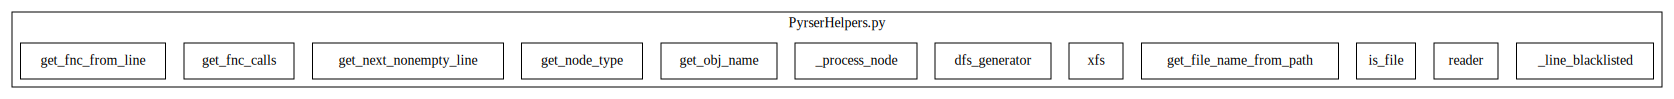

In [8]:
test

In [9]:
print(test)

// PyrserHelpers.py
digraph {
	subgraph "cluster_PyrserHelpers.py" {
		_line_blacklisted [shape=box]
		reader [shape=box]
		is_file [shape=box]
		get_file_name_from_path [shape=box]
		xfs [shape=box]
		dfs_generator [shape=box]
		_process_node [shape=box]
		get_obj_name [shape=box]
		get_node_type [shape=box]
		get_next_nonempty_line [shape=box]
		get_fnc_calls [shape=box]
		get_fnc_from_line [shape=box]
		label="PyrserHelpers.py"
	}
}


In [10]:
add_edges(output, test)

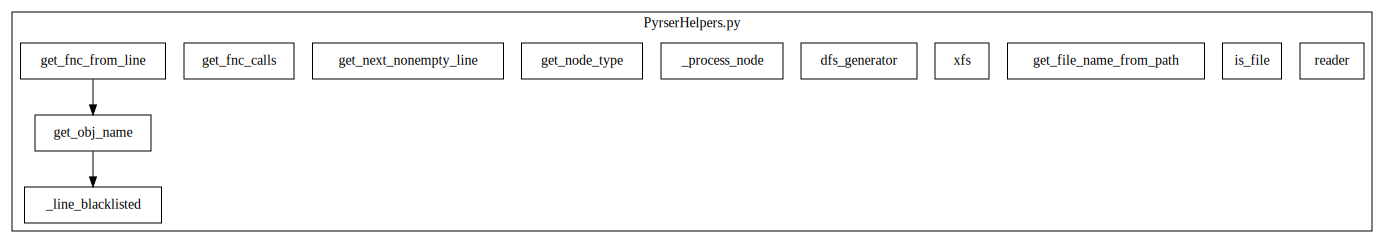

In [11]:
test